<a href="https://colab.research.google.com/github/SLKS99/-Physics-driven-discovery-and-optimization-of-hybrid-perovskite-films/blob/main/Experimental_thin_films_of_MAPbI3%2BGAPbBr3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import Modules

import numpy as np
import pandas as pd


#Plotting Tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import matplotlib.colors as mcolors
import seaborn as sns

#gdown Installation
!pip install gdown==3.6.0




  Preparing metadata (setup.py) ... done
  Created wheel for gdown: filename=gdown-3.6.0-py3-none-any.whl size=5221 sha256=21f7c2338a143feaf56c39a870abc9f456f1d406ac8f7d41715325ab13d9618f
  Stored in directory: /root/.cache/pip/wheels/a7/00/af/7528f0f7a7cd3f085b4b79d81e49744946b654fb19dd979363
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


# GP and sGP for the exploration of bandgap vs concentration

August 2023

*   Data Collection performed by Elham Foadian
* Analysis performed by [Sheryl L. Sanchez](https://scholar.google.com/citations?hl=en&user=zFRKT-MAAAAJ)



In [ ]:

#Machine Learning Tools
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [ ]:

plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "normal"
plt.rcParams['axes.titleweight']='bold'

#PL

## User Input

In [ ]:
#@title Experimental Data



#Wells that we should ignore
wells_to_ignore = 'A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B2,B3,B5,B7,B9,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,D2,D3,D5,D7,D9,D11,D12,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,F2,F4,F6,F8,F10,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H2,H4,H6,H8,H9,H10,H11,H12'
#C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,D11,E11,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,A12,B12,C12,D12,E12,F12,G12,H12' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 500 #@param {type:"integer"}
end_wavelength =  850 #@param {type:"integer"}
wavelength_step_size =  1 #@param {type:"integer"}

time_step = 12 #@param {type:"integer"}

#Information about the reads
number_of_reads =   1#@param {type:"integer"}
luminescence_read_numbers = '1'
#2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59'

# Convert the string into a list to use later
if len(wells_to_ignore) != 0:
  wells_to_ignore = list(wells_to_ignore.split(","))

if len(luminescence_read_numbers) != 0:
  luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [ ]:
#@title Data Information

#Name of files
data_file_name = '9-20-23sGP-20films-PL.csv' #@param {type:'string'}


data_file = '17El42kdP0SNAb6DBnSdyOGCP3AOTCxlt' #@param {type:"string"}

composition_file_name = '4-20-23 GAPbBr3 compositions.csv' #@param {type:'string'}

#Download the correct data

composition_file = '16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz' #@param {type:"string"}


## Downloading and Formating Data

In [ ]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}


!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=17El42kdP0SNAb6DBnSdyOGCP3AOTCxlt
To: /content/9-20-23sGP-20films-PL.csv
100% 61.5k/61.5k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz
To: /content/4-20-23 GAPbBr3 compositions.csv
100% 598/598 [00:00<00:00, 1.88MB/s]


In [ ]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name,header=None)
rawData = rawData.replace('OVRFLW', np.NaN)
rawData = rawData.replace(r'^\s*$', np.NaN, regex=True)

composition = pd.read_csv(composition_file_name, index_col = 0)



In [ ]:
#@title Parsing the Data into a Dictionary
cells = []

for i in range(1, 9):
  for j in range(1 , 13):
    cells.append(chr(64 + i) + str(j))

for i in wells_to_ignore:
  cells.remove(i)

for i in wells_to_ignore:
  composition = composition.drop(i, axis = 1)
if not luminescence_read_numbers:
  for i in luminescence_read_numbers:
    cells= cells.remove(i)

#First the rows of measurements
rows = []

for i in range(1, number_of_reads + 1):

  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()
  #rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':Spectrum'].index.tolist()
rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes

#First step, make a list of the names
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary
d = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values
  d[c] = d[c].drop([0], axis = 1) #Drop the empty column

  new_header = d[c].iloc[0] #grab the first row for the header
  d[c] = d[c][1:] #take the data less the header row
  d[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore:
    d[c] = d[c].drop(i, axis = 1)
  d[c] = d[c].astype(float) #Make sure that it is composed of numbers



In [ ]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]

#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:

  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

#luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)



<ipython-input-9-90de53d05770>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])


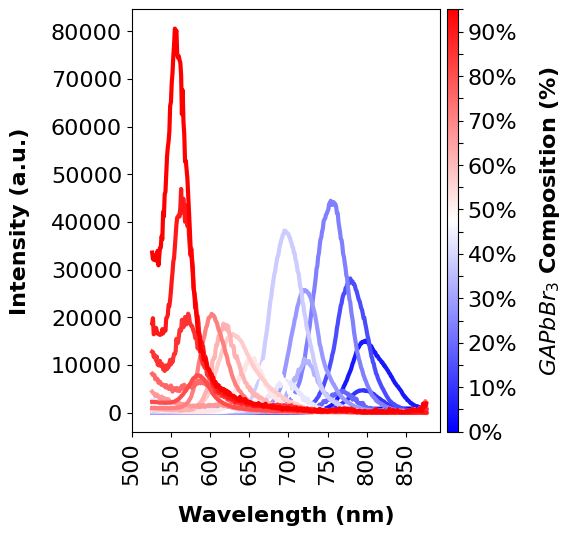

In [ ]:




luminescence_wavelength = np.arange(start_wavelength, end_wavelength + wavelength_step_size, wavelength_step_size)

# Plot the normalized data
ax = d['Read 1'].plot(layout=(8, 13), figsize=(5, 5), cmap='bwr', linewidth=3, legend=False)
plt.tight_layout()
ax.set_xticks(np.arange(0, len(luminescence_wavelength), 50))
ax.set_xticklabels(luminescence_wavelength[0::50], rotation='vertical')

plt.xlabel('Wavelength (nm)', labelpad=15, size=16)
plt.ylabel('Intensity (a.u.)', labelpad=15, size=16)

# Create a ScalarMappable for colorbar
norm = mcolors.Normalize(vmin=0, vmax=1)  # Define the color normalization range
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array([])  # Dummy array for colorbar

# Add colorbar for the percentage labels
composition_labels = ['0%', '', '10%', '', '20%', '', '30%', '', '40%', '', '50%', '', '60%', '', '70%','','80%','','90%','']
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=40, ticks=np.linspace(0, 1, len(composition_labels)))
cbar.ax.set_ylabel('$GAPbBr_3$ Composition (%)', labelpad=15, size=16)
cbar.set_ticklabels(composition_labels)

plt.show()


In [ ]:
compositions = composition.values.T
targets = d['Read 1'].values.T

luminescence_wavelength = np.arange(
    start_wavelength,end_wavelength + wavelength_step_size, wavelength_step_size)

print(compositions.shape, targets.shape, luminescence_wavelength.shape)

(20, 2) (21, 351) (351,)


<Axes: >

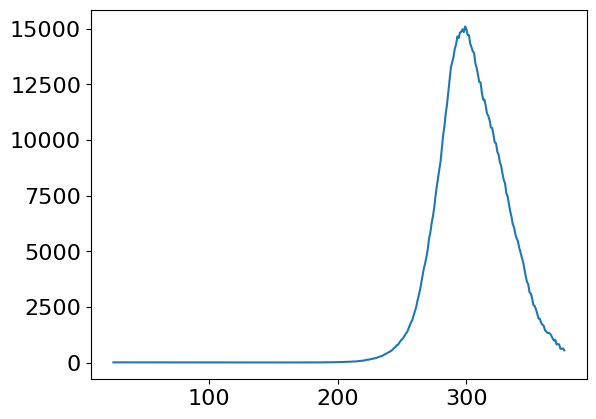

In [ ]:
d['Read 1']['B1'].plot()

529 80552.0


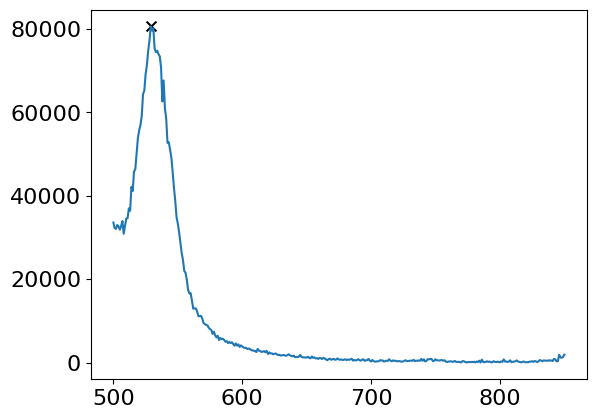

In [ ]:


k = 20
# Plot the data
plt.plot(luminescence_wavelength, targets[k])

# Manually identify the peak location
peak_pos = np.argmax(targets[k])
peak_int = targets[k][peak_pos]

# Plot the peak
plt.scatter(luminescence_wavelength[peak_pos], peak_int, marker='x', s=50, c='k')

# Print the peak position and intensity
print(luminescence_wavelength[peak_pos], peak_int)


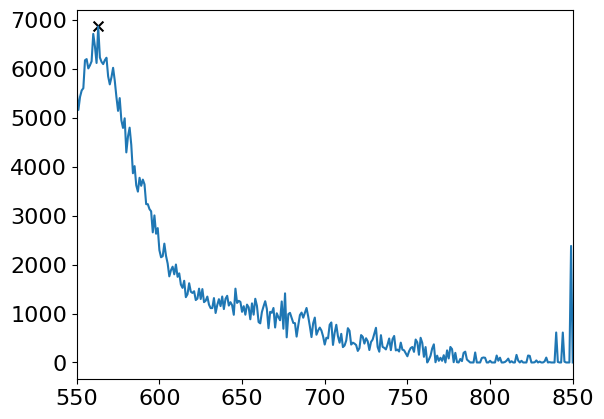

563 6868.0


In [ ]:
# Mask the data to the range of interest
mask = (luminescence_wavelength >= 550) & (luminescence_wavelength <= 850)
masked_wavelength = luminescence_wavelength[mask]
masked_targets = targets[k][mask]

# Identify the peak location within the masked data
peak_pos = np.argmax(masked_targets)
peak_int = masked_targets[peak_pos]

# Plot the data
plt.plot(masked_wavelength, masked_targets)

# Mark the peak
plt.scatter(masked_wavelength[peak_pos], peak_int, marker='x', s=50, c='k')
plt.xlim(550, 850)

plt.show()

# Print the peak position and intensity
print(masked_wavelength[peak_pos], peak_int)


In [ ]:

luminescence= luminescence_df.drop(['Wavelength'],axis=1)

In [ ]:
scaler= MinMaxScaler()
arr_scaled = scaler.fit_transform(luminescence)
luminescence_norm = pd.DataFrame(arr_scaled, columns=luminescence.columns,index=luminescence.index)

print(luminescence_norm.describe())

luminescence=np.array(luminescence)

25        B2          B4          B6          B8         B10          D1  \
count  351.0  351.000000  351.000000  351.000000  351.000000  351.000000   
mean     0.0    0.152899    0.144481    0.136546    0.154283    0.140779   
std      0.0    0.284110    0.274278    0.258780    0.285602    0.271110   
min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.000213    0.000071    0.000876    0.000158    0.000117   
50%      0.0    0.001704    0.003590    0.003724    0.005560    0.006036   
75%      0.0    0.130990    0.117273    0.110515    0.130135    0.110237   
max      0.0    1.000000    1.000000    1.000000    1.000000    1.000000   

25             D4          D6          D8         D10          F1          F3  \
count  351.000000  351.000000  351.000000  351.000000  351.000000  351.000000   
mean     0.124486    0.152871    0.185628    0.149290    0.130746    0.187718   
std      0.243257    0.283678    0.245720    0.269683    0.247186    0.2

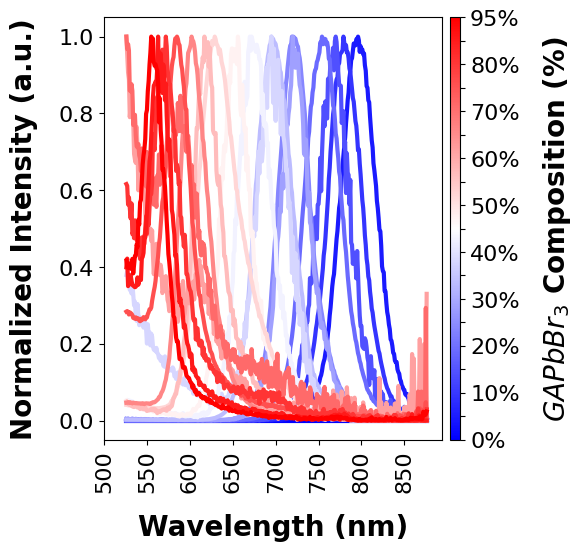

In [ ]:



luminescence_wavelength = np.arange(start_wavelength, end_wavelength + wavelength_step_size, wavelength_step_size)

# Plot the normalized data
ax = luminescence_norm.plot(layout=(8, 13), figsize=(5, 5), cmap='bwr', linewidth=3, legend=False)
plt.tight_layout()
ax.set_xticks(np.arange(0, len(luminescence_wavelength), 50))
ax.set_xticklabels(luminescence_wavelength[0::50], rotation='vertical')

plt.xlabel('Wavelength (nm)', labelpad=15, size=20)
plt.ylabel('Normalized Intensity (a.u.)', labelpad=15, size=20)

# Create a ScalarMappable for colorbar
norm = mcolors.Normalize(vmin=0, vmax=1)  # Define the color normalization range
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array([])  # Dummy array for colorbar

# Add colorbar for the percentage labels
composition_labels = ['0%', '', '10%', '', '20%', '', '30%', '', '40%', '', '50%', '', '60%', '', '70%','','80%','','95%']
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=40, ticks=np.linspace(0, 1, len(composition_labels)))
cbar.ax.set_ylabel('$GAPbBr_3$ Composition (%)', labelpad=15, size=20)
cbar.set_ticklabels(composition_labels)

plt.show()


In [ ]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]


#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:

  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)

luminescence_vec = np.array(luminescence_df)


<ipython-input-54-07aa31db6eef>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])


In [ ]:
luminescence_vec.shape


(351, 22)

<ipython-input-205-8b9aa2cdebb8>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(luminescence_vec[:,:].T), cmap='RdYlBu_r', aspect=7, origin='lower') #YlGnBu RdYlBu_r


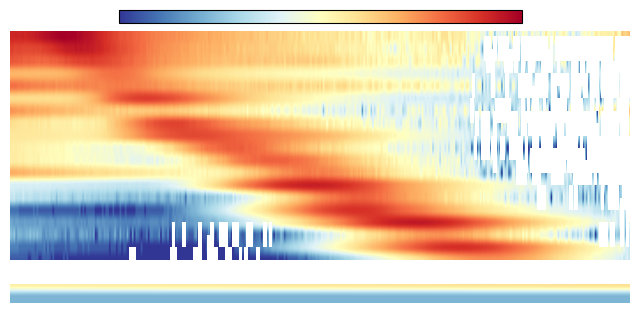

In [ ]:

plt.figure(figsize=(8,10))
plt.imshow(np.log(luminescence_vec[:,:].T), cmap='RdYlBu_r', aspect=7, origin='lower') #YlGnBu RdYlBu_r
plt.axis('off')

cbar=plt.colorbar(shrink=0.65, aspect=30, pad=0.01, orientation='horizontal', location='top')
cbar.set_ticks([])
plt.show()

#Absorbance

In [ ]:
#@title Experimental Data



#Wells that we should ignore
wells_to_ignore_abs = 'A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B1,B3,B5,B7,B9,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,D2,D3,D5,D7,D9,D11,D12,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,F2,F4,F6,F8,F10,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H2,H4,H6,H8,H9,H10,H11,H12'
#C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,D11,E11,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,A12,B12,C12,D12,E12,F12,G12,H12' #@param {type:"string"}

#Information about Measurement Range
start_wavelength_abs = 400 #@param {type:"integer"}
end_wavelength_abs =  850 #@param {type:"integer"}
wavelength_step_size_abs =  1 #@param {type:"integer"}

time_step = 12 #@param {type:"integer"}

#Information about the reads
number_of_reads =   1#@param {type:"integer"}
luminescence_read_numbers = '1'
#2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59'

# Convert the string into a list to use later
if len(wells_to_ignore_abs) != 0:
  wells_to_ignore_abs = list(wells_to_ignore_abs.split(","))

if len(luminescence_read_numbers) != 0:
  luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [ ]:
#@title Data Information

#Name of files
data_file_name_abs = '9-20-23sGP-20films-ABS.csv' #@param {type:'string'}
composition_file_name = '4-20-23 GAPbBr3 compositions.csv' #@param {type:'string'}

#Download the correct data
data_file_abs = '1ASESDORR2dku0foQZdiOP2_LzzzsAN25' #@param {type:"string"}
composition_file = '16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz' #@param {type:"string"}

In [ ]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file_abs}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=1ASESDORR2dku0foQZdiOP2_LzzzsAN25
To: /content/9-20-23sGP-20films-ABS.csv
100% 263k/263k [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz
To: /content/4-20-23 GAPbBr3 compositions.csv
100% 598/598 [00:00<00:00, 2.80MB/s]


In [ ]:
#@title Into Pandas Dataframes
rawData_abs = pd.read_csv(data_file_name_abs, header=None)
rawData_abs = rawData_abs.replace('OVRFLW', np.NaN)

rawData_abs = rawData_abs.replace(r'^\s*$', np.nan, regex=True) #if blank add this
composition = pd.read_csv(composition_file_name, index_col = 0)


In [ ]:
#@title Parsing the Data into a Dictionary
cells = []

for i in range(1, 9):
  for j in range(1 , 13):
    cells.append(chr(64 + i) + str(j))


for i in wells_to_ignore_abs:
  composition = composition.drop(i, axis = 1)

#First the rows of measurements
rows = []

for i in range(1, number_of_reads + 1):

  rows += rawData_abs[rawData_abs[rawData_abs.columns[0]] == 'Read ' + str(i) + ':Spectrum'].index.tolist()

rows += rawData_abs[rawData_abs[rawData_abs.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes

#First step, make a list of the names
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary
d_abs = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d_abs[c] = rawData_abs[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values
  d_abs[c] = d_abs[c].drop([0], axis = 1) #Drop the empty column
  d_abs[c]=d_abs[c].drop([1],axis=1)  # this is to drop the wavelength column only giving the composition values


  new_header = d_abs[c].iloc[0] #grab the first row for the header
  d_abs[c] = d_abs[c][1:] #take the data less the header row
  d_abs[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore_abs:
    d_abs[c] = d_abs[c].drop(i, axis = 1)
  d_abs[c] = d_abs[c].astype(float) #Make sure that it is composed of numbers


In [ ]:
#@title Convert the Dictionary into an Array


#Convert wavelength information into an array
luminescence_wavelength_abs = np.arange(start_wavelength_abs,end_wavelength_abs + wavelength_step_size_abs,wavelength_step_size_abs)



#Load information into a dataframe
luminescence_df_abs = pd.DataFrame()

for i in luminescence_read_numbers:

  luminescence_df_abs  = luminescence_df_abs.append(d_abs['Read ' +str(i)])

#luminescence_df_abs.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df_abs = luminescence_df_abs.fillna(0.0)



<ipython-input-19-21259e39b42a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df_abs  = luminescence_df_abs.append(d_abs['Read ' +str(i)])


In [ ]:
# Drop the first 100 rows
d_abs['Read 1'] = d_abs['Read 1'].iloc[100:, :]


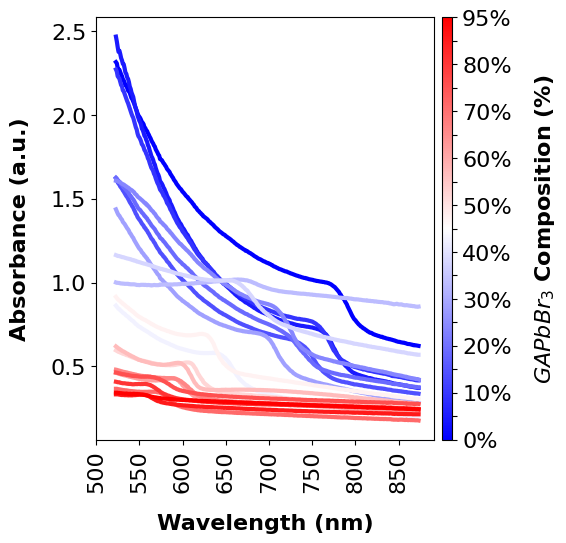

In [ ]:



# Plot the data
ax = d_abs['Read 1'].plot(layout=(8, 13), figsize=(5, 5), cmap='bwr', linewidth=3, legend=False)
plt.tight_layout()

ax.set_xticks([100,150,200,250,300,350,400,450])
ax.set_xticklabels([500,550,600,650,700,750,800,850],rotation='vertical')
plt.xlabel('Wavelength (nm)', labelpad=15, size=16)
plt.ylabel('Absorbance (a.u.)', labelpad=15, size=16)

# Create a ScalarMappable for colorbar
norm = mcolors.Normalize(vmin=0, vmax=1)  # Define the color normalization range
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array([])  # Dummy array for colorbar

# Add colorbar for the percentage labels
composition_labels = ['0%', '', '10%', '', '20%', '', '30%', '', '40%', '', '50%', '', '60%', '', '70%','','80%','','95%']
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=40, ticks=np.linspace(0, 1, len(composition_labels)))
cbar.ax.set_ylabel('$GAPbBr_3$ Composition (%)', labelpad=15, size=16)
cbar.set_ticklabels(composition_labels)
#plt.xlim(450,850)
plt.show()


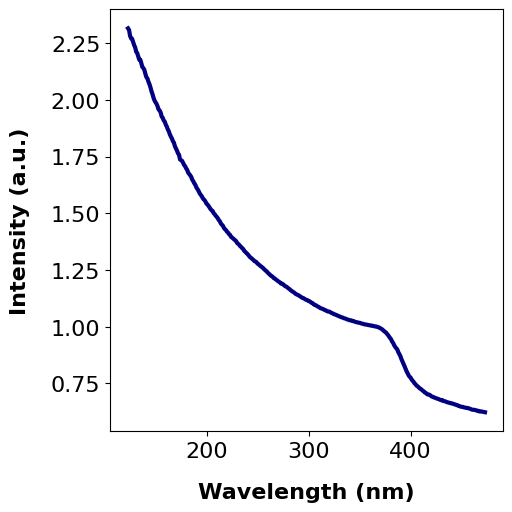

<Figure size 640x480 with 0 Axes>

In [ ]:

ax=d_abs[c]['B2'].plot(x=luminescence_wavelength_abs,layout=(8,13),figsize=(5,5),cmap='jet',linewidth=3,legend=False)
plt.tight_layout()
#ax.set_xticks(np.arange(0,len(luminescence_wavelength),10))
#ax.set_xticklabels(luminescence_wavelength[0::10], rotation='horizontal')
plt.xlabel('Wavelength (nm)', labelpad=15,size=16)
plt.ylabel('Intensity (a.u.)', labelpad=15,size=16)

plt.show()
plt.savefig('PL of GA addition.tif', bbox_inches='tight',dpi=300)

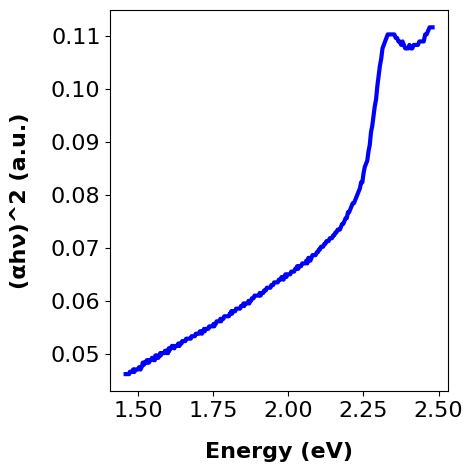

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjusting luminescence_wavelength range and step
luminescence_wavelength = np.arange(500, 851, 1)

# 1. Calculate energy (hν) from wavelength
energy = 1240 / luminescence_wavelength

# 2. Extract absorbance data from dataframe
absorbance = d_abs[c]['H5'].values

# Assuming direct bandgap for this example:
alpha_hv = np.power(absorbance, 2)

# 3. Plot
plt.figure(figsize=(5,5))
plt.plot(energy, alpha_hv, color='b', linewidth=3)

plt.xlabel('Energy (eV)', labelpad=15, size=16)
plt.ylabel('(αhν)^2 (a.u.)', labelpad=15, size=16)

plt.tight_layout()

plt.show()
plt.savefig('Tauc_Plot.tif', bbox_inches='tight', dpi=300)


In [ ]:
import numpy as np
import csv

# Load the data
data = np.array(d_abs[c])

# Extract composition and absorbance values
composition = data[:, 0]
absorbance = data[:, 1:]

# Convert wavelength to energy (eV)
luminescence_wavelength = np.arange(500, 851, 1)
energy = 1240 /luminescence_wavelength

# Calculate (alpha * h * nu)^2 for each composition
ahnu_squared_list = []
for i in range(absorbance.shape[1]):
    ahnu_squared = (2.303 * energy * absorbance[:, i]) ** 2
    ahnu_squared_list.append(ahnu_squared)

# Prepare data for CSV
csv_data = np.column_stack([composition] + [energy] + ahnu_squared_list)
csv_file = "composition_data.csv"

# Save data to CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Composition", "Energy (eV)"] + [f"Composition {i+1} (alpha * h * nu)^2" for i in range(len(composition))])
    writer.writerows(csv_data)


Bandgap: 2.06 eV


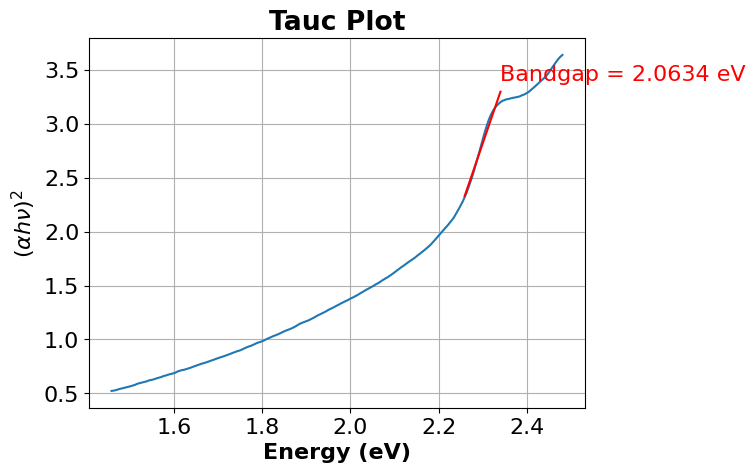

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
from scipy.stats import linregress
import matplotlib.pyplot as plt
import csv

# Load your data here. For this example, I'm assuming you have it loaded into 'data'.
data = np.array(d_abs[c]['H5'])

# Convert wavelength to energy (eV)
luminescence_wavelength = np.arange(500, 851, 1)
energy = 1240 / luminescence_wavelength

# Calculate (alpha * h * nu)^2
ahnu_squared = (2.303 * energy * data) ** 2

# Apply Savitzky-Golay smoothing
smoothed_data = savgol_filter(ahnu_squared, 11, 3)

# Save smoothed data to CSV
csv_data = np.column_stack((energy, smoothed_data))
csv_file = "tauc_plot_data.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Energy (eV)", "$(\\alpha h \\nu)^2$"])
    writer.writerows(csv_data)

# Plot the Tauc plot
plt.plot(energy, smoothed_data)
plt.xlabel("Energy (eV)")
plt.ylabel("$(\\alpha h \\nu)^2$")
plt.title("Tauc Plot")
plt.grid(True)

# Calculate the bandgap using automated linear regression
dydx_smooth = np.gradient(smoothed_data, energy)
max_index = np.argmax(dydx_smooth)

# Define the range around the absorption edge for linear regression
# Modify these values if needed based on your visual inspection
start_range = max_index - 10
end_range = max_index + 10

x_linear = energy[start_range:end_range]
y_linear = smoothed_data[start_range:end_range]

if len(x_linear) == 0 or len(y_linear) == 0:
    print("No data points found within the specified energy range.")
else:
    slope, intercept, r_value, p_value, stderr = linregress(x_linear, y_linear)
    bandgap = -intercept / slope
    print("Bandgap: {:.2f} eV".format(bandgap))

    # Plot the linear fit
    plt.plot(x_linear, slope * x_linear + intercept, color='red')
    plt.annotate(f"Bandgap = {bandgap:.4f} eV", xy=(x_linear[0], slope * x_linear[0] + intercept + 0.1), color='red')

# Save the figure and show the plot
plt.savefig("tauc_plot.png")
plt.show()


#PL by Time

In [ ]:
#@title Experimental Data



#Wells that we should ignore
wells_to_ignore = 'A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B1,B3,B5,B7,B9,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,D2,D3,D5,D7,D9,D11,D12,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,F2,F4,F6,F8,F10,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H2,H4,H6,H8,H9,H10,H11,H12'
#C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,D11,E11,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,A12,B12,C12,D12,E12,F12,G12,H12' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 450 #@param {type:"integer"}
end_wavelength =  850 #@param {type:"integer"}
wavelength_step_size =  2 #@param {type:"integer"}

time_step = 8 #@param {type:"integer"}

#Information about the reads
number_of_reads =   100#@param {type:"integer"}
luminescence_read_numbers = '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100'
#2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59'

# Convert the string into a list to use later
if len(wells_to_ignore) != 0:
  wells_to_ignore = list(wells_to_ignore.split(","))

if len(luminescence_read_numbers) != 0:
  luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [ ]:
#@title Data Information

#Name of files
data_file_name = '9-21-23 sGP over time 5 percent.csv' #@param {type:'string'}
composition_file_name = '4-20-23 GAPbBr3 compositions.csv' #@param {type:'string'}

#Download the correct data
data_file = '1M4-5_L5AR1JA3Tu5i29ZiTHhmEdVU3DE' #@param {type:"string"}
composition_file = '16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz' #@param {type:"string"}

In [ ]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=1M4-5_L5AR1JA3Tu5i29ZiTHhmEdVU3DE
To: /content/9-21-23 sGP over time 5 percent.csv
100% 9.57M/9.57M [00:00<00:00, 34.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz
To: /content/4-20-23 GAPbBr3 compositions.csv
100% 598/598 [00:00<00:00, 2.56MB/s]


In [ ]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name, header=None)
#rawData = rawData.replace('OVRFLW', np.NaN)

#rawData = rawData.replace(r'^\s*$', np.nan, regex=True) #if blank add this
composition = pd.read_csv(composition_file_name, index_col = 0)


In [ ]:
import pandas as pd
import numpy as np

# Sample data loading
# rawData = pd.read_csv(data_file_name,header=None)
# composition = pd.read_csv(composition_file_name, index_col = 0)

# Convert the dataframe to numeric and ignore errors (errors turned to NaN)
numeric_data = rawData.apply(pd.to_numeric, errors='coerce')

# Get the maximum value from the numeric data
max_value = numeric_data.max().max()

# Replace 'OVRFLW' with the max_value
rawData.replace('OVRFLW', max_value, inplace=True)

# If there's a need to also replace empty strings with NaN
rawData.replace(r'^\s*$', np.NaN, regex=True, inplace=True)


In [ ]:
#@title Parsing the Data into a Dictionary
cells = []

for i in range(1, 9):
  for j in range(1 , 13):
    cells.append(chr(64 + i) + str(j))


for i in wells_to_ignore:
  composition = composition.drop(i, axis = 1)

#First the rows of measurements
rows = []

for i in range(1, number_of_reads + 1):

  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()

rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes

#First step, make a list of the names
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary
d = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values
  d[c] = d[c].drop([0], axis = 1) #Drop the empty column
  d[c]=d[c].drop([1],axis=1)  # this is to drop the wavelength column only giving the composition values


  new_header = d[c].iloc[0] #grab the first row for the header
  d[c] = d[c][1:] #take the data less the header row
  d[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore:
    d[c] = d[c].drop(i, axis = 1)
  d[c] = d[c].astype(float) #Make sure that it is composed of numbers


In [ ]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]


#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:

  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)

luminescence_vec = np.array(luminescence_df)


<ipython-input-12-07aa31db6eef>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])
<ipython-input-12-07aa31db6eef>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])
<ipython-input-12-07aa31db6eef>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])
<ipython-input-12-07aa31db6eef>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])
<ipython-input-12-07aa31db6eef>:18: FutureWarning: The frame.append 

In [ ]:
luminescence_vec.shape


(20100, 21)

In [ ]:
luminescence_wavelength.shape

(201,)

In [ ]:
20100/201


100.0

In [ ]:
ldata = luminescence_vec.reshape([100,201,21])
print(ldata.shape, luminescence_wavelength.shape)
print(luminescence_wavelength.max())

(100, 201, 21) (201,)
850


In [ ]:
ldata_re = ldata[:,:,1:]

<ipython-input-18-1e42bdf141bb>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(ldata_re[:,25:,19]), cmap='RdYlBu_r',origin='lower') #YlGnBu RdYlBu_r


(-0.5, 175.5, -0.5, 99.5)

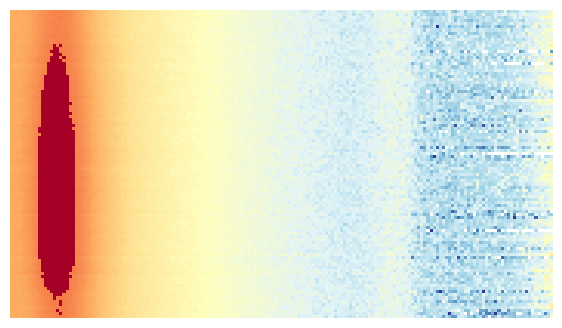

In [ ]:
plt.figure(figsize=(10,4))
plt.imshow(np.log(ldata_re[:,25:,19]), cmap='RdYlBu_r',origin='lower') #YlGnBu RdYlBu_r
plt.axis('off')

(0.0, 176.0, 0.0, 100.0)

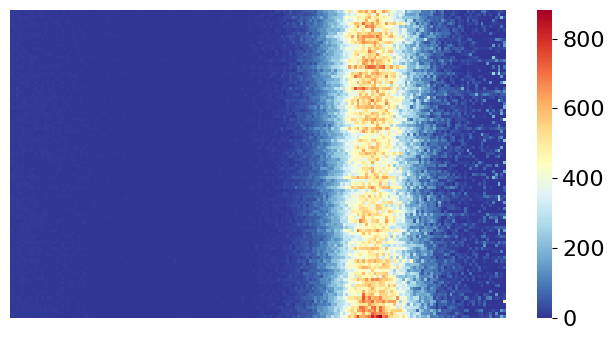

In [ ]:
new_luminescence_wavelength = luminescence_wavelength[25:]  # Starts from 500 to 850


plt.rcParams['font.size'] = 16
plt.figure(figsize=(8,4))
ax2=sns.heatmap(ldata[:,25:,3], cmap='RdYlBu_r')
ax2.invert_yaxis()
plt.axis('off')
#ax2.set_yticks([0,20,40,60,80])
#ax2.set_yticklabels([0,140,280,420,560])
#ax2.set_xticks(np.arange(0, len(new_luminescence_wavelength), 25))
#ax2.set_xticklabels(new_luminescence_wavelength[0::25], rotation='horizontal')
#ax2.set_xlabel('Wavelength (nm)', labelpad=10, size=20)
#ax2.set_ylabel('Time (min)', labelpad=15, size=20)